<a href="https://colab.research.google.com/github/atulvats/Imaging_Based_Deep_Learning_for_Kidney_Disease_Detection/blob/main/Imaging_Based_Deep_Learning_for_Kidney_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Kidney CT Scan Classification with Xception and Grad-CAM**

This notebook implements a deep learning solution for classifying kidney CT scans into four categories: Normal, Cyst, Tumor, and Stone. The solution addresses class imbalance and includes Grad-CAM visualization and a Streamlit UI.

**1. Setup and Installation**

First, let's install all required packages:

In [ ]:
!pip install -q tensorflow streamlit pillow opencv-python imbalanced-learn matplotlib seaborn pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 3.8 MB/s eta 0:00:00


**2. Import Libraries**

Import all necessary Python libraries:

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import cv2
from PIL import Image
import time
import zipfile
from pyngrok import ngrok

**3. Data Preparation**

Mount Google Drive and Download Dataset

In [ ]:
base_dir = "/content/drive/MyDrive/data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"

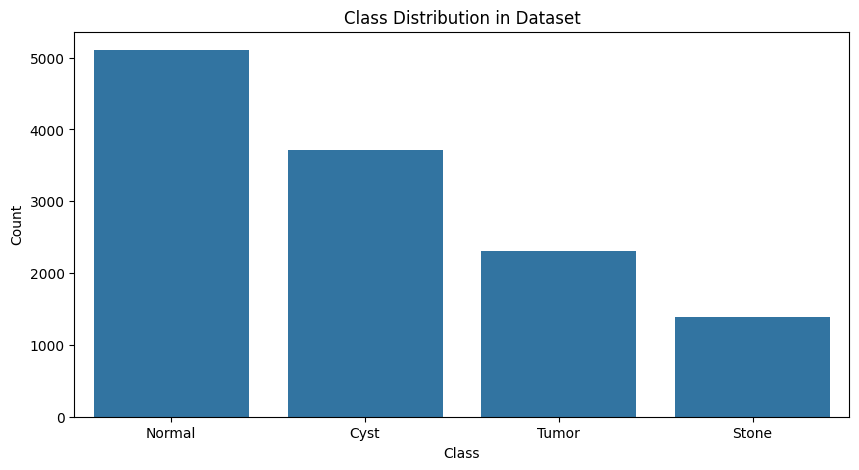

In [ ]:
classes = ['Normal', 'Cyst', 'Tumor', 'Stone']

class_counts = {}
for cls in classes:
    class_counts[cls] = len(os.listdir(os.path.join(base_dir, cls)))

# Plot class distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Class Distribution in Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

**4. Data Preprocessing**

We'll use ImageDataGenerator for data augmentation and preprocessing:

In [ ]:
# Image parameters
img_size = (299, 299)  # Xception default input size
batch_size = 32

# Create data generators with augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Using 20% for validation
)

# Load and augment data
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Handle class imbalance
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

Found 10021 images belonging to 4 classes.
Found 2503 images belonging to 4 classes.


**5. Model Building**

We'll use Xception with transfer learning:

In [ ]:
# Build Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add[0][0]       

 Total params: 22,963,756 (87.60 MB)

 Trainable params: 2,102,276 (8.02 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

**6. Model Training**

Let's train the model with callbacks

In [ ]:
# Callbacks
checkpoint = ModelCheckpoint('best_kidney_model.h5',
                            monitor='val_accuracy',
                            save_best_only=True,
                            mode='max',
                            verbose=1)

early_stopping = EarlyStopping(monitor='val_loss',
                              patience=5,
                              restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=3,
    callbacks=[checkpoint, early_stopping],
    class_weight=class_weights
)

Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.5902 - loss: 1.0157 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.64904, saving model to best_kidney_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 5831s 19s/step - accuracy: 0.5905 - loss: 1.0152 - val_accuracy: 0.6490 - val_loss: 0.8950
Epoch 2/3
  1/313 ━━━━━━━━━━━━━━━━━━━━ 1:13:27 14s/step - accuracy: 0.7812 - loss: 0.9488

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.64904
313/313 ━━━━━━━━━━━━━━━━━━━━ 1172s 4s/step - accuracy: 0.7812 - loss: 0.9488 - val_accuracy: 0.6126 - val_loss: 0.9200
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.7890 - loss: 0.5727 
Epoch 3: val_accuracy did not improve from 0.64904
313/313 ━━━━━━━━━━━━━━━━━━━━ 5721s 18s/step - accuracy: 0.7891 - loss: 0.5727 - val_accuracy: 0.6022 - val_loss: 0.9075


**Plot Training History**

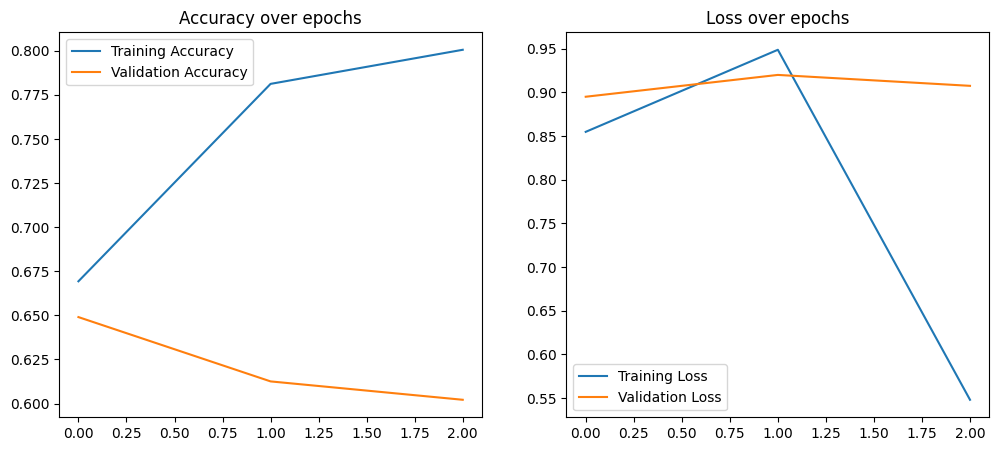

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

**7. Fine-Tuning**

Let's unfreeze some layers for fine-tuning:

In [ ]:
# Fine-tuning (unfreeze some layers)
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune for a few more epochs
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=3,
    callbacks=[checkpoint, early_stopping],
    class_weight=class_weights
)

Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.7932 - loss: 0.6411 
Epoch 1: val_accuracy improved from 0.64904 to 0.68309, saving model to best_kidney_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 8209s 26s/step - accuracy: 0.7933 - loss: 0.6408 - val_accuracy: 0.6831 - val_loss: 0.7298
Epoch 2/3
  1/313 ━━━━━━━━━━━━━━━━━━━━ 1:47:30 21s/step - accuracy: 0.8750 - loss: 0.2867

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.68309 to 0.69832, saving model to best_kidney_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 1127s 4s/step - accuracy: 0.8750 - loss: 0.2867 - val_accuracy: 0.6983 - val_loss: 0.7339
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.8927 - loss: 0.3210 
Epoch 3: val_accuracy improved from 0.69832 to 0.74159, saving model to best_kidney_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 8335s 27s/step - accuracy: 0.8928 - loss: 0.3208 - val_accuracy: 0.7416 - val_loss: 0.6265


**8. Grad-CAM Implementation**

Let's implement Grad-CAM for model interpretability:

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (299, 299))

    heatmap = np.uint8(255 * heatmap)
    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = cv2.resize(jet_heatmap, (img.shape[1], img.shape[0]))
    jet_heatmap = (jet_heatmap * 255).astype(np.uint8)
    superimposed_img = jet_heatmap * alpha + img * (1 - alpha)
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(heatmap, cmap='hot')
    ax[1].set_title('Heatmap')
    ax[1].axis('off')

    ax[2].imshow(superimposed_img)
    ax[2].set_title('Grad-CAM')
    ax[2].axis('off')
    plt.show()


Save the Model

In [ ]:
# Save model in recommended format
model.save('best_kidney_model.keras')  # Or .h5 if you prefer

from google.colab import files
files.download('best_kidney_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Launch the Web App**

In [ ]:
!pip install -q gradio tensorflow pillow numpy

In [ ]:
import tensorflow as tf
from google.colab import files
uploaded = files.upload()

# Load your saved Keras model
model = tf.keras.models.load_model('best_kidney_model.keras')  # or .h5

Saving best_kidney_model.keras to best_kidney_model.keras


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 45 variables whereas the saved optimizer has 88 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import gradio as gr
from PIL import Image

# Verify GPU
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Load model with error handling
try:
    model = tf.keras.models.load_model('best_kidney_model.keras')
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    try:
        model = tf.keras.models.load_model('best_kidney_model.h5')
        print("Model loaded from .h5 file!")
    except:
        raise ValueError("Could not load model. Please check file path/format.")

class_names = ['Cyst', 'Normal', 'Stone', 'Tumor']  # Update if needed

def preprocess_image(img):
    """Convert Gradio Image object to preprocessed numpy array"""
    img = np.array(img)
    if len(img.shape) == 2:  # Grayscale to RGB
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = cv2.resize(img, (299, 299))
    return tf.keras.applications.xception.preprocess_input(img)

def predict_with_gradcam(img):
    try:
        img_np = np.array(img)

        if len(img_np.shape) == 2 or img_np.shape[2] == 1:
            img_np = cv2.cvtColor(img_np, cv2.COLOR_GRAY2RGB)

        resized_img = cv2.resize(img_np, (299, 299))
        preprocessed_img = tf.keras.applications.xception.preprocess_input(resized_img)
        img_array = np.expand_dims(preprocessed_img, axis=0)

        # Prediction
        preds = model.predict(img_array, verbose=0)
        pred_class = class_names[np.argmax(preds)]
        confidence = float(np.max(preds)) * 100

        # Grad-CAM
        last_conv_layer = model.get_layer("block14_sepconv2")  # << fixed here
        grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])

        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(img_array)
            pred_index = tf.argmax(predictions[0])
            class_channel = predictions[:, pred_index]

        grads = tape.gradient(class_channel, conv_outputs)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        conv_outputs = conv_outputs[0]

        heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1).numpy()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1

        # Resize heatmap to match original image
        heatmap_resized = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

        superimposed_img = cv2.addWeighted(img_np.astype(np.uint8), 0.6, heatmap_colored, 0.4, 0)

        return pred_class, confidence, superimposed_img

    except Exception as e:
        print(f"Prediction error: {e}")
        return "Error", 0, None

# Create Gradio interface
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("""
    # 🏥 Kidney CT Scan Classifier
    Upload a kidney CT scan to classify it as Normal, Cyst, Tumor, or Stone.
    Also view a Grad-CAM heatmap highlighting important regions.
    """)

    with gr.Row():
        with gr.Column():
            image_input = gr.Image(
                label="CT Scan Image",
                type="pil",
                image_mode="RGB",
            )
            submit_btn = gr.Button("Analyze", variant="primary")

        with gr.Column():
            label_output = gr.Label(label="Prediction")
            confidence_output = gr.Number(
                label="Confidence (%)",
                precision=2
            )
            heatmap_output = gr.Image(
                label="Grad-CAM Heatmap",
                interactive=False
            )

    submit_btn.click(
        fn=predict_with_gradcam,
        inputs=image_input,
        outputs=[label_output, confidence_output, heatmap_output]
    )

    gr.Examples(
        examples=[
            "/content/kidney_ct/normal/1.jpg",  # Example images
            "/content/kidney_ct/stone/2.jpg"
        ],
        inputs=image_input
    )

# Launch the Gradio app
demo.launch(debug=True, share=True)


GPU Available: []


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 45 variables whereas the saved optimizer has 88 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model loaded successfully!
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://2cd438285ee5cb9708.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 299, 299, 3))
  warnings.warn(msg)
